# Boxworld 

- A simple grid environment based loosely on the classic japanese game 'Sokoban'
The game of Sokoban is a a classical japanese game...

# The environment
The environment is a NxN array of integers. Each cell of this environment can have the following values:

- 0 : empty cell
- 1 : obstacle, non-traversable
- 2 : Box
- 3 : Storage location

All border cells are obstacles. Upon initialization, the environment has:

- 1 Box placed randomly in the environment
- Storage locations (exits) placed in the corners of the environment

# The game

The agent starts in a random empty cell, and has to move the box into one of the storage locations. 

At each timestep:

- the agent decides on an action (move up, left, right or down)
- the action is sent to the environment
- the environment sends back the state, as well as observations, rewards and a boolean that indicates whether the environment terminated.
- The environment terminates if the agent reaches the exit, 

??or if the environement reaches a time limit of N**4 timesteps.??

# States

Since both the agent and box can be in any of the (free) cells in the grid,
the state space is O(N**4)

# Observations

Each timestep, the agent is told how far away it is from the box. This distance is not euclidean, but rather is the length of
the shortest path between the agent and the box

# Rewards

The agent recieves a reward each timestep, depending on where the action takes it:
- If the agent bumps into a wall, it will recieve a reward of -5
- If the agent pushes the box, it will recieve a reward of +1
**This is to incentivize the agent into pushing the box rather than wandering around it
- If the agent pushes the box into a wall, it will recieve a reward of -10, and both the agent and the box will remain at their original locations
- If the agent correctly places the box, it will recieve a reward of N* N
- Additionally, the agent will recieve a reward of -1 each timestep

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import namedtuple




In [155]:
# First define a namedtuple to hold useful information for actions
Action = namedtuple('Action', 'name index delta_i delta_j' )
up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1) 

# Use a dictionary to convert indices to actions using the index as a key
# Useful for sampling actions for a given state
index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action 
    
# Helpful function to convert action in string format to the action object
str_to_actions = {}
for action in [up,down,left,right]:
    str_to_actions[action.name] = action




class Boxworld():
    def __init__(self, N):
        self.boxworld = np.zeros((N,N))
        self.size = N
        
        #Reward/transition/Value matrices
        self.reward_matrix = -1*np.ones( (N**4,4))
        self.transition_matrix = np.zeros((N**4,4,N**4))
        
        
        self.boxworld[0, :] = 1 #top row
        self.boxworld[:, 0] = 1 # left column
        self.boxworld[-1, :] = 1 # bottom row
        self.boxworld[:, -1] = 1 #right column
        
        # All corners will be possible exits
        self.exits = [[1,1],[1,-2],[-2,1],[-2,-2] ]
        for corner in self.exits:
            self.boxworld[corner[0],corner[1]] = 3
        

       
        # Agent's position will be determined upon reset
        self.position_agent = None
        
        box_cell = np.asarray(self.get_empty_cells(1))
        self.position_box = box_cell
        
                                        

        # run time
        self.time_elapsed = 0
        self.time_limit = self.size**4
        
        # display help
        self.dict_map_display={ 0:'.',
                                1:'X',
                                2:'B',
                                3:'E',
                                4:'A'}
                                #5:'!'}
        
        
        # Assign random index for each coordinate in the grid
        index_coords = np.arange(0,N*N)
        np.random.shuffle(index_coords)
        self.coord_to_index = index_coords.reshape(N,N)
        
        # Then combine pairs of indices to get a single state for the environment 
        index_states = np.arange(0,N**4)
        np.random.shuffle(index_states)
        self.index_pairs_to_state = index_states.reshape(N*N,N*N)
        
        #Fill the matrices
        # ** TO-DO: clean up?
        # Iterate over all possible box & agent locations
        for k in range(1,N-1):
            for l in range(1,N-1):
                for i in range(1,N-1):
                    for j in range(1,N-1):
                        
                        # First calculate current indices, state, cell type
                        current_agent_index = self.coord_to_index[i,j]
                        current_box_index = self.coord_to_index[k,l]
                        current_state = self.index_pairs_to_state[current_box_index,current_agent_index]
                        current_cell = self.boxworld[i,j]

                    
                        for action in [up,left,down,right]:
                            # Lookahead one step for agent
                            dest_coords = [i+action.delta_i,j+action.delta_j]
                            destination_cell = self.boxworld[dest_coords[0],dest_coords[1]]
                            next_agent_index = self.coord_to_index[dest_coords[0],dest_coords[1]]                            
                            
                            #Write NAN when box and agent overlap...
                            #if current_agent_index == current_box_index:
                                #self.reward_matrix[current_state, action.index] = np.NAN
                            
                            # Check for direct bump between agent and wall
                            if destination_cell == 1:
                                self.transition_matrix[current_state, action.index, current_state] = 1 
                                #destination_cell = current_cell 
                                #next_state = current_state
                                self.reward_matrix[current_state, action.index] += -5   
                        
                            # Case when agent moves to other valid cell
                            if destination_cell in [0,3]:
                                next_state = self.index_pairs_to_state[current_box_index,next_agent_index]
                                self.transition_matrix[current_state,action.index,next_state] = 1
                            
                            # Case when agent pushes box
                            if next_agent_index == current_box_index:
                                
                                # Update reward matrix for a push
                                self.reward_matrix[current_state,action.index]+=1
                                
                                # Case when agent pushes box into wall
                                if self.boxworld[i+(2*action.delta_i),j+(2*action.delta_j)] ==1:
                                    self.transition_matrix[current_state, action.index, current_state] = 1
                                    #destination_cell = current_cell
                                    self.reward_matrix[current_state,action.index]+=-10
                                
                                # Else look at cases when push is valid
                                else:
                                    # Now calculate one-step lookahead for box
                                    box_dest_coords = [i + (2 * action.delta_i), j + (2*action.delta_j)]
                                    destination_box_cell = self.boxworld[box_dest_coords[0], box_dest_coords[1]]
                                    next_box_index = self.coord_to_index[box_dest_coords[0], box_dest_coords[1]]
                                    next_state = self.index_pairs_to_state[next_box_index,next_agent_index]
                                    
                                    # Transition is valid so update the matrix
                                    self.transition_matrix[current_state,action.index,next_state] = 1
                                    
                                    # Update reward matrix for a valid push
                                    self.reward_matrix[current_state,action.index]+=1
                                    
                                    # Case when box is pushed to correct location
                                    if destination_box_cell == 3:
                                        self.reward_matrix[current_state,action.index]+=N**2
                                        
                                    # Case when box is pushed to incorrect corner
                                    #if destination_box_cell == 4:
                                        #self.reward_matrix[current_state,action.index] += -N**2
                                        
                            
                                
                            
        
    # Function that takes an action in string form, and returns coordinates after the given action.
    def next_pos(self,str_act, old_pos):
        action = str_to_actions[str_act]
        next_position = [old_pos[0]+action.delta_i,old_pos[1]+action.delta_j]
        return np.array(next_position)
        
        
    # Given an action, recieve information from the environment
    def step(self, action):
        
        reward = -1
        bump = False
        push = False
        done = False
        
        # Store new agent position
        next_agent_position = self.next_pos(action, self.position_agent)

        # First check if agent bumps into wall directly
        if self.boxworld[next_agent_position[0],next_agent_position[1]] ==1:
            bump = True
            
        
        # Now see if agent pushes box
        if (next_agent_position == self.position_box).all():
            
            push= True

            
            # Find new box position
            next_box_position = self.next_pos(action, self.position_box)

            
            # Check if box get pushed into wall
            if self.boxworld[next_box_position[0], next_box_position[1]] == 1:
                reward-=10
            
            # Otherwise move agent and box
            if self.boxworld[next_box_position[0], next_box_position[1]] in [0,3,4]:
                self.position_box = next_box_position
                self.position_agent = next_agent_position
                
                
        # Case where agent moves into any other valid cell 
        elif self.boxworld[next_agent_position[0],next_agent_position[1]] !=1:
            self.position_agent = next_agent_position
                
        # Calculate rewards
        box_cell_type = self.boxworld[self.position_box[0],self.position_box[1]]
        if box_cell_type == 3:
            reward+=self.size**2
            done = True
            
        #if cell_type==4:
            #reward-=self.size**2
            #print("Episode Failed! (Reached dead state)")
            #done = True

        # Penalise any kind of bump
        if bump:
            reward -=5
        
        # Reward any kind of push
        if push:
            reward+=1
            
        # get observations & state
        obs = self.calculate_observations()
        
        state = self.index_pairs_to_state[self.coord_to_index[self.position_agent[0],self.position_agent[1]],
                                    self.coord_to_index[self.position_box[0],self.position_box[1]] ]                                   
        
        # Update time
        self.time_elapsed +=1
        if self.time_elapsed == self.time_limit:
            done = True
            print("Time limit expired!")

        
        return state, obs, reward, done
    
    def display(self):
        
        envir_with_agent = self.boxworld.copy() 
        envir_with_agent[self.position_agent[0], self.position_agent[1]] = 4
        envir_with_agent[self.position_box[0], self.position_box[1]] = 2
        full_repr = ""

        for r in range(self.size):
            
            line = ""
            
            for c in range(self.size):

                string_repr = self.dict_map_display[ envir_with_agent[r,c] ] #display
                
                line += "{0:2}".format(string_repr)

            full_repr += line + "\n"

        print(full_repr)

        
    # A function to print a  'snapshot' of possible rewards from current timestep
    def print_reward_matrices(self):
        
        for action in [up,down,left,right]:
            
            # Get index of box coordinates
            box_index = self.coord_to_index[self.position_box[0],self.position_box[1]]

            
            # New matrix to display rewards            
            reward_matrix =  np.zeros( (self.size,self.size) )
            
            for i in range(1, self.size-1):
                    for j in range(1, self.size-1):

                        agent_index = self.coord_to_index[i,j]
                        state = self.index_pairs_to_state[box_index,agent_index]
                        reward_matrix[i,j] = self.reward_matrix[state, action.index]
                        
            print( action.name)
            print(reward_matrix) #for the given action, what reward would I get if I took that action from a particular state?
    

        
    def calculate_observations(self):
        
        agent_coordinates = self.position_agent
        box_coordinates = self.position_box 
        
        # Calculate  the squares between the agent and box?
        distance = abs(agent_coordinates[0] - box_coordinates[0]) + abs(agent_coordinates[1] - box_coordinates[1]) 
        obs = {'Squares between agent and box': distance}
        return obs
        

    def get_empty_cells(self, n_cells): 
        empty_cells_coord = np.where( self.boxworld == 0 ) #find empty cells
        selected_indices = np.random.choice( np.arange(len(empty_cells_coord[0])), n_cells ) 
        selected_coordinates = empty_cells_coord[0][selected_indices], empty_cells_coord[1][selected_indices] #turn into coordinates
        
        if n_cells == 1:
            return np.asarray(selected_coordinates).reshape(2,) 
        
        return selected_coordinates
        
    def reset(self):
        """
        This function resets the environment to its original state (time = 0).
        Then it places the agent and exit at new random locations.
        
        """
        self.time_elapsed = 0
        
        # position of the agent is a numpy array
        empty_cells = np.asarray(self.get_empty_cells(1))
        self.position_agent = empty_cells

        
        # In the case where box and agent reset to same location, repeat until they no longer do
        if (self.position_agent == self.position_box).all():
                self.reset()
                
        # Same for case where box resets to an exit
        #for exit in self.exits:
            #if (self.position_box == exit).all():
                #self.reset()

        # Calculate observations
        observations = self.calculate_observations()
        
        
        state = self.index_pairs_to_state[ self.coord_to_index[self.position_agent[0], self.position_agent[1]],
                                          self.coord_to_index[self.position_box[0],self.position_box[1]] ]
        
        return state

In [156]:
boxworld = Boxworld(5)
boxworld.reset()
boxworld.display()


X X X X X 
X E B E X 
X . . . X 
X E A E X 
X X X X X 



In [157]:
boxworld.reset()
boxworld.display()

X X X X X 
X E B E X 
X . . . X 
X E A E X 
X X X X X 



In [158]:
state, obs, rew, done = boxworld.step('up')
print(obs,rew,done)
boxworld.display()
boxworld.print_reward_matrices()

{'Squares between agent and box': 1} -1 False
X X X X X 
X E B E X 
X . A . X 
X E . E X 
X X X X X 

up
[[  0.   0.   0.   0.   0.]
 [  0.  -6.  -6.  -6.   0.]
 [  0.  -1. -10.  -1.   0.]
 [  0.  -1.  -1.  -1.   0.]
 [  0.   0.   0.   0.   0.]]
down
[[ 0.  0.  0.  0.  0.]
 [ 0. -1. -1. -1.  0.]
 [ 0. -1. -1. -1.  0.]
 [ 0. -6. -6. -6.  0.]
 [ 0.  0.  0.  0.  0.]]
left
[[ 0.  0.  0.  0.  0.]
 [ 0. -6. -1. 26.  0.]
 [ 0. -6. -1. -1.  0.]
 [ 0. -6. -1. -1.  0.]
 [ 0.  0.  0.  0.  0.]]
right
[[ 0.  0.  0.  0.  0.]
 [ 0. 26. -1. -6.  0.]
 [ 0. -1. -1. -6.  0.]
 [ 0. -1. -1. -6.  0.]
 [ 0.  0.  0.  0.  0.]]


# Testing

Below are some useful functions for testing different policies on Boxworld

In [159]:
# Function to run a single episode in a fresh instance of a given environment and policy
def run_single_exp(env,policy):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = policy(state)
        state, obs, reward, done = env.step(action)
        total_reward+=reward
        
    return total_reward


# Function to run a number of experiments, returning summarized information of all the runs
def run_experiments(envir, policy, number_exp):
    
    all_rewards = []
    
    for i in range(number_exp):
        
        final_reward = run_single_exp(envir, policy)
        all_rewards.append(final_reward)
    
    max_reward = max(all_rewards)
    mean_reward = np.mean(all_rewards)
    var_reward = np.std(all_rewards)
    
    return all_rewards, max_reward, mean_reward, var_reward

# Learning

In [160]:
class Policy():
    
    def __init__(self,environment,gamma):
        self.env = environment
        self.size_env= environment.size
        self.reward_matrix = environment.reward_matrix
        self.transition_matrix = environment.transition_matrix
        self.coord_to_index = environment.coord_to_index
        self.index_pairs_to_state = environment.index_pairs_to_state
        self.size_state_space = environment.size**4
        
        # Initialize policy to be a random one
        self.probability_actions = np.ones((self.size_state_space, 4))*0.25 
        
        # We initialize the values to 0
        self.values = np.zeros( self.size_state_space )   
        
        # Discount factor
        self.gamma = gamma
     
    # Function which samples an action, given a state
    def __call__(self,state):
        
        # Find the probabilities of actions for the given state
        prob_actions = self.probability_actions[state]
        
        # Randomly sample index from this
        index = np.random.choice(np.arange(prob_actions.size))
        return index_to_actions[index].name
    
    

    
    # Function that uses a given policy to evaluate the value functions for each state
    def iterative_policy_evaluation(self,n_sweeps):
        
        # Reset the values
        self.values = np.zeros(self.size_state_space)
        
        # Then use bellman expectation equation to iteratively update values
        for n in range(n_sweeps):
            
            self.values = np.sum(self.probability_actions * (self.reward_matrix + 
                                 self.gamma* np.dot(self.transition_matrix,self.values)), axis=1 )
            
    # ** Need to pass env in order to get current coordinates of box (in init would only get starting coords...)        
    def display_values(self,env):
        
        value_matrix = np.zeros( (self.size_env,self.size_env) )
        
        # Get index of box coordinates
        box_index = self.coord_to_index[env.position_box[0],env.position_box[1]]
            
        for i in range(1, self.size_env-1):
                for j in range(1, self.size_env-1):

                    agent_index = self.coord_to_index[i,j]
                    state = self.index_pairs_to_state[box_index,agent_index]
                    value_matrix[i,j] = self.values[state]
                        
        return value_matrix
    
    def greedy_improvement(self):
        
        # Get indices of 'best' actions
        argmax_actions = np.argmax(self.reward_matrix + self.gamma * np.dot(self.transition_matrix,self.values), axis=1 )
        
        #Then update policy for each state
        for state in range(self.size_state_space):
            
            greedy_index = argmax_actions[state]
            
            #But only update if this transition is possible!
            if self.transition_matrix[state][greedy_index].sum()!=0:
                
                self.probability_actions[state,:] = 0
                self.probability_actions[state,greedy_index] = 1
                
            
    
    #A function that iteratively evaluates and improves a policy 
    def policy_iteration(self, n_evaluations):
        
        self.iterative_policy_evaluation(n_evaluations)
        self.greedy_improvement()

X X X X X X X 
X E . . A E X 
X . . . B . X 
X . . . . . X 
X . . . . . X 
X E . . . E X 
X X X X X X X 



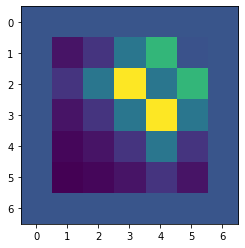

In [161]:
boxworld = Boxworld(7)
boxworld.reset()
policy = Policy(boxworld,gamma=0.4)

# Apply a single greedy improvement, after 25 sweeps
for i in range(25):
    values = policy.iterative_policy_evaluation(10)
    policy.greedy_improvement()

boxworld.display()
vals = policy.display_values(boxworld)

plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
plt.show()

In [162]:
# Run a few 
all_rew, max_rew, mean_rew, var_rew = run_experiments(boxworld,policy,10)
print(f'Rewards: {all_rew} \nLargest Reward: {max_rew} \nMean reward: {mean_rew}')

Rewards: [-683, 48, 48, 48, 48, 48, 48, 48, 48, 48] 
Largest Reward: 48 
Mean reward: -25.1


In [163]:
boxworld = Boxworld(8)
# Expect a high gamma to be better, as agent needs to be farsighted in an environment like this
gamma = 1

policy = Policy(boxworld,gamma)

# Let's now see how our agent does after repeatedly improving the policy
for n_improvements in range(20):
    
    values = policy.policy_iteration(n_evaluations=20)
    
    _, max_reward, mean_reward, var_reward = run_experiments(boxworld, policy, number_exp=20)
    
    print(n_improvements, mean_reward)



0 -31.95
1 62.75
2 62.55
3 63.0
4 62.75
5 62.25
6 61.55
7 62.5
8 62.75
9 61.55
10 62.75
11 62.5
12 61.55
13 62.3
14 62.05
15 61.8
16 62.5
17 62.25
18 61.75
19 63.0


# Plots

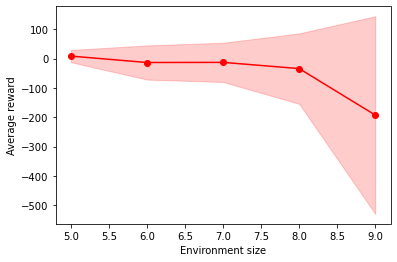

In [166]:
n_environments_per_size=5
n_runs_per_environments=5
gamma = 0.9

mean_reward = []
std_reward = []
    
for size_envir in range(5,10):

    # heuristics
    n_improvement_steps = size_envir
    n_steps_policy_eval = 10
    
    total_rewards = []

    for n_envir in range(n_environments_per_size):

        boxworld = Boxworld(size_envir)
        policy = Policy(boxworld, gamma)
        
        for n_improvements in range(n_improvement_steps):
    
            policy.policy_iteration(n_steps_policy_eval)

        all_total_rewards, _, _, _ = run_experiments(boxworld, policy, n_runs_per_environments)

        total_rewards += all_total_rewards

    mean_reward.append( np.mean(total_rewards) )
    std_reward.append( np.std(total_rewards) )

mean_reward = np.asarray(mean_reward)
std_reward = np.asarray(std_reward)

plt.plot(range(5, 10), mean_reward, 'or')
plt.plot(range(5, 10), mean_reward, color = 'r')
plt.fill_between(range(5, 10), mean_reward - std_reward/2, mean_reward + std_reward/2,
             color='r', alpha=0.2)

plt.xlabel('Environment size')
plt.ylabel('Average reward')

plt.show()

The above graph shows how the variance increases sharply once environment reaches 9
This could be explained by the fact that, at larger environment sizes, the agent has to be very farsighted
to figure out the optimal strategy